In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
import numpy as np
from tensorflow import keras

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.layers import GaussianNoise
import pandas as pd

random.seed(0)


class DQNAgent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, time = 30000):
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = env.observation_space
        #self.memory = deque(maxlen=2000) # Record past experiences- [(state, action, reward, next_state, done)...]
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning = True
        self.model = self._build_model()
        self.memory = []
        self.counter = 0
        self.fit_interval = 100
        self.thompson_alpha = np.ones(self.env.action_space.n)
        self.thompson_beta = np.ones(self.env.action_space.n)
        self.time = time 
        self.time_left = time # Epsilon Decay
        self.small_decrement = (0.4 * epsilon) / (0.3 * self.time_left) # reduce epsilon
        print('HELLO')
    
    # Build Neural Net
    def _build_model(self):
#         print(type(self.state_size))
        model = Sequential()
        model.add(Dense(320, input_shape = (2,), kernel_initializer='random_uniform', activation='relu'))
        model.add(Dense(160, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.alpha))
        
        return model
       
#     # Remember function that stores states, actions, rewards, and done to memory
#     def remember(self, state, action, reward, next_state, done):
#         self.memory.append([state, action, reward, next_state, done])

    def choose_action(self, state):
        """
        Choose which action to take, based on the observation. 
        Uses greedy epsilon for exploration/exploitation.
        """

        # if random number > epsilon, act 'rationally'. otherwise, choose random action
        action_value = np.array([])
        if np.random.rand() <= self.epsilon:
            action = random.randrange(self.action_size)
            
        else:
            action_value = self.model.predict(state,verbose=0)
            action = np.argmax(action_value[0])
        
        self.update_parameters()
        return action_value,action
    
    

    def boltzmann_action(self, state):
        action_value = self.model.predict(state,verbose=0)
        current_action_values =action_value[0]
    
        exp_probabilities = np.exp(current_action_values / 0.1 )
        probabilities = exp_probabilities / np.sum(exp_probabilities)
        action = np.random.choice(range(self.action_size), p=probabilities)
        return action_value,action 
        
    def thompson_sampling(self):
        theta = np.random.beta(self.thompson_alpha, self.thompson_beta)
        return theta, theta.argmax() 
    
        
        
    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
#         print(self.time_left)
        if self.time_left > 0.9 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.7 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.5 * self.time:
            self.epsilon -= self.small_decrement
#             print('0.5')
        elif self.time_left > 0.3 * self.time:
#             print('0.2')
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.1 * self.time:
            self.epsilon -= self.small_decrement
#         elif self.time_left < 0.05 * self.time:
#             self.epsilon = 0.000
#             self.learning = False

#         print(self.time_left)
        #         print(self.time)
        if self.epsilon <= 0.1:
            self.epsilon = 0.1
        self.time_left -= 1       


        
    def update_thompson_action(self, reward,action):
        self.thompson_alpha[action] += reward
        
        if self.thompson_alpha[action] <= 0 :
            self.thompson_alpha[action] = 1e-10 
        
        self.thompson_beta[action] += 1 - reward
        if self.thompson_beta[action] <= 0 :
            self.thompson_beta[action] = 1e-10 
    
    def learn(self, state, action, reward, next_state, done, action_value):
        
        
#         minibatch = random.sample(self.memory, batch_size)
#         print(minibatch)
        
#         print('STATE: ' + str(state))
#             print('next_state: ' + str(state))

#         print('target: ' + str(target))


#         print('target: ' + str(target))


#         print('action: ' + str(action))
#             print(self.model.predict(next_state))
#         print(np.amax(self.model.predict(next_state)[0]))

#         print(target_f)
#         print('target_f: ' + str(target_f))


#         print('target_f: ' + str(target_f))
#             print('target_f: ' + str(target_f))
#         print('-------')

        #self.model.fit(state, target_f, epochs=1, verbose=0)
        self.update_thompson_action(reward,action)
        #self.memory.append((state, action, reward, next_state, done, action_value))

        #self.counter += 1
        #if self.counter % self.fit_interval == 0:
            #self._fit_model()
        
        
#             print(self.time)
#         print(self.epsilon)

    def _fit_model(self):
            states = []
            targets = []
            for state, action, reward, next_state, done, action_value in self.memory:
                target = reward
                if not done:
                    target += self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
                target_f = action_value
                if (np.size(action_value) == 0):
                    target_f = self.model.predict(state,verbose=0)
                target_f[0][action] = target
                states.append(state[0])
                targets.append(target_f[0])
            self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
            self.memory = []
    def get_optimal_strategy(self):
        index = []
        for x in range(0,21):
            for y in range(1,11):
                index.append((x,y))

        df = pd.DataFrame(index = index, columns = ['Stand', 'Hit'])

        for ind in range(0,21):
            outcome = self.model.predict([np.array([index[ind]])], batch_size=1,verbose=0)
            df.loc[ind, 'Stand'] = outcome[0][0]
            df.loc[ind, 'Hit'] = outcome[0][1]


        df['Optimal'] = df.apply(lambda x : 'Hit' if x['Hit'] >= x['Stand'] else 'Stand', axis=1)
        df.to_csv('optimal_policy.csv')
        return df

In [ ]:

from blackjackenv import BlackjackEnv
env = BlackjackEnv()
env.reset()
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt
from collections import deque
import time

start_time = time.time()

# print(agent.model)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 200 # num_rounds simulated over num_samples

agent = DQNAgent(env=env, epsilon=1, alpha=0.001, gamma=0.001, time=7500)

average_payouts = []

state,_ = env.reset()
state = np.reshape(state[0:2], [1,2])
for sample in range(num_samples):
    round = 1
    total_payout = 0 # store total payout per sample
    while round <= num_rounds:
        action_value, action = agent.boltzmann_action(state)
        next_state, payout, done, _, _ = env.step(action)
        next_state = np.reshape(next_state[0:2], [1,2])

        
        total_payout += payout    
#         if agent.learning:
        agent.learn(state, action, payout, next_state, done, action_value)
        
        state = next_state
        state = np.reshape(state[0:2], [1,2])
        
        if done:
            state,_ = env.reset() # Environment deals new cards to player and dealer
            state = np.reshape(state[0:2], [1,2])
            round += 1

    average_payouts.append(total_payout)

    if sample % 10 == 0:
        print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
        print(agent.epsilon)

print(agent.get_optimal_strategy())

# Plot payout per 1000 episodes for each value of 'sample'

plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))


C:\Users\87235\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


HELLO


C:\Users\87235\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


HELLO
Done with sample: 0   --- 0.26600122451782227 seconds ---
1
Done with sample: 10   --- 1.4289989471435547 seconds ---
1
Done with sample: 20   --- 2.5919976234436035 seconds ---
1
Done with sample: 30   --- 3.7664968967437744 seconds ---
1
Done with sample: 40   --- 4.9159979820251465 seconds ---
1
Done with sample: 50   --- 6.085001230239868 seconds ---
1
Done with sample: 60   --- 7.261500597000122 seconds ---
1
Done with sample: 70   --- 8.429498434066772 seconds ---
1
Done with sample: 80   --- 9.608500719070435 seconds ---
1
Done with sample: 90   --- 10.768501043319702 seconds ---
1
Done with sample: 100   --- 11.946998596191406 seconds ---
1
Done with sample: 110   --- 13.107497215270996 seconds ---
1
Done with sample: 120   --- 14.267500162124634 seconds ---
1
Done with sample: 130   --- 15.423997163772583 seconds ---
1
Done with sample: 140   --- 16.571000814437866 seconds ---
1
Done with sample: 150   --- 17.743000745773315 seconds ---
1
Done with sample: 160   --- 18.9

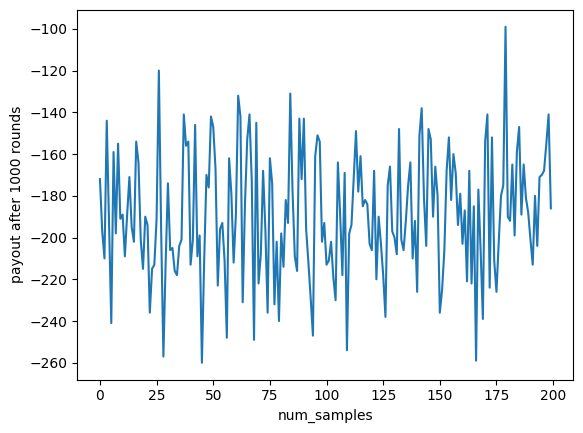

Average payout after 1000 rounds is -188.855


In [5]:

from blackjackenv import BlackjackEnv
env = BlackjackEnv()
env.reset()
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt
from collections import deque
import time

start_time = time.time()

# print(agent.model)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 200 # num_rounds simulated over num_samples

agent = DQNAgent(env=env, epsilon=1, alpha=0.001, gamma=0.001, time=7500)

average_payouts = []

state,_ = env.reset()
state = np.reshape(state[0:2], [1,2])
for sample in range(num_samples):
    round = 1
    total_payout = 0 # store total payout per sample
    while round <= num_rounds:
        action_value, action = agent.thompson_sampling()
        next_state, payout, done, _, _ = env.step(action)
        next_state = np.reshape(next_state[0:2], [1,2])

        
        total_payout += payout    
#         if agent.learning:
        agent.learn(state, action, payout, next_state, done, action_value)
        
        state = next_state
        state = np.reshape(state[0:2], [1,2])
        
        if done:
            state,_ = env.reset() # Environment deals new cards to player and dealer
            state = np.reshape(state[0:2], [1,2])
            round += 1

    average_payouts.append(total_payout)

    if sample % 10 == 0:
        print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
        print(agent.epsilon)

print(agent.get_optimal_strategy())

# Plot payout per 1000 episodes for each value of 'sample'

plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))


In [1]:

from blackjackenv import BlackjackEnv
env = BlackjackEnv()
env.reset()
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt
from collections import deque
import time

start_time = time.time()

# print(agent.model)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 200 # num_rounds simulated over num_samples

agent = DQNAgent(env=env, epsilon=1, alpha=0.001, gamma=0.001, time=7500)

average_payouts = []

state,_ = env.reset()
state = np.reshape(state[0:2], [1,2])
for sample in range(num_samples):
    round = 1
    total_payout = 0 # store total payout per sample
    while round <= num_rounds:
        action_value, action = agent.choose_action(state)
        next_state, payout, done, _, _ = env.step(action)
        next_state = np.reshape(next_state[0:2], [1,2])

        
        total_payout += payout    
#         if agent.learning:
        agent.learn(state, action, payout, next_state, done, action_value)
        
        state = next_state
        state = np.reshape(state[0:2], [1,2])
        
        if done:
            state,_ = env.reset() # Environment deals new cards to player and dealer
            state = np.reshape(state[0:2], [1,2])
            round += 1

    average_payouts.append(total_payout)

    if sample % 10 == 0:
        print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
        print(agent.epsilon)

print(agent.get_optimal_strategy())

# Plot payout per 1000 episodes for each value of 'sample'

plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))


NameError: name 'DQNAgent' is not defined

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
import numpy as np
from tensorflow import keras

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.layers import GaussianNoise
import pandas as pd

random.seed(0)


class DQNAgent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, time = 30000):
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = env.observation_space
        #self.memory = deque(maxlen=2000) # Record past experiences- [(state, action, reward, next_state, done)...]
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning = True
        self.model = self._build_model()
        self.memory = []
        self.counter = 0
        self.fit_interval = 100
        self.thompson_alpha = np.ones(self.env.action_space.n)
        self.thompson_beta = np.ones(self.env.action_space.n)
        self.time = time 
        self.time_left = time # Epsilon Decay
        self.small_decrement = (0.4 * epsilon) / (0.3 * self.time_left) # reduce epsilon
        print('HELLO')
    
    # Build Neural Net
    def _build_model(self):
#         print(type(self.state_size))
        model = Sequential()
        model.add(Dense(320, input_shape = (2,), kernel_initializer='random_uniform', activation='relu'))
        model.add(GaussianNoise(0.1))
        model.add(Dense(160, activation='relu'))
        model.add(GaussianNoise(0.1))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.alpha))
        
        return model
       
#     # Remember function that stores states, actions, rewards, and done to memory
#     def remember(self, state, action, reward, next_state, done):
#         self.memory.append([state, action, reward, next_state, done])

    def choose_action(self, state):
        """
        Choose which action to take, based on the observation. 
        Uses greedy epsilon for exploration/exploitation.
        """

        # if random number > epsilon, act 'rationally'. otherwise, choose random action
        action_value = np.array([])
        if np.random.rand() <= self.epsilon:
            action = random.randrange(self.action_size)
            
        else:
            action_value = self.model.predict(state,verbose=0)
            action = np.argmax(action_value[0])
        
        self.update_parameters()
        return action_value,action
    
    

    def boltzmann_action(self, state):
        action_value = self.model.predict(state,verbose=0)
        current_action_values =action_value[0]
    
        exp_probabilities = np.exp(current_action_values / 0.1 )
        probabilities = exp_probabilities / np.sum(exp_probabilities)
        action = np.random.choice(range(self.action_size), p=probabilities)
        return action_value,action 
        
    def thompson_sampling(self):
        theta = np.random.beta(self.thompson_alpha, self.thompson_beta)
        return theta, theta.argmax() 
    
        
        
    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
#         print(self.time_left)
        if self.time_left > 0.9 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.7 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.5 * self.time:
            self.epsilon -= self.small_decrement
#             print('0.5')
        elif self.time_left > 0.3 * self.time:
#             print('0.2')
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.1 * self.time:
            self.epsilon -= self.small_decrement
#         elif self.time_left < 0.05 * self.time:
#             self.epsilon = 0.000
#             self.learning = False

#         print(self.time_left)
        #         print(self.time)
        if self.epsilon <= 0.1:
            self.epsilon = 0.1
        self.time_left -= 1       


        
    def update_thompson_action(self, reward,action):
        self.thompson_alpha[action] += reward
        
        if self.thompson_alpha[action] <= 0 :
            self.thompson_alpha[action] = 1e-10 
        
        self.thompson_beta[action] += 1 - reward
        if self.thompson_beta[action] <= 0 :
            self.thompson_beta[action] = 1e-10 
    
    def learn(self, state, action, reward, next_state, done, action_value):
        
        
#         minibatch = random.sample(self.memory, batch_size)
#         print(minibatch)
        
#         print('STATE: ' + str(state))
#             print('next_state: ' + str(state))

#         print('target: ' + str(target))


#         print('target: ' + str(target))


#         print('action: ' + str(action))
#             print(self.model.predict(next_state))
#         print(np.amax(self.model.predict(next_state)[0]))

#         print(target_f)
#         print('target_f: ' + str(target_f))


#         print('target_f: ' + str(target_f))
#             print('target_f: ' + str(target_f))
#         print('-------')

        #self.model.fit(state, target_f, epochs=1, verbose=0)
        self.update_thompson_action(reward,action)
        #self.memory.append((state, action, reward, next_state, done, action_value))

        #self.counter += 1
        #if self.counter % self.fit_interval == 0:
            #self._fit_model()
        
        
#             print(self.time)
#         print(self.epsilon)

    def _fit_model(self):
            states = []
            targets = []
            for state, action, reward, next_state, done, action_value in self.memory:
                target = reward
                if not done:
                    target += self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
                target_f = action_value
                if (np.size(action_value) == 0):
                    target_f = self.model.predict(state,verbose=0)
                target_f[0][action] = target
                states.append(state[0])
                targets.append(target_f[0])
            self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
            self.memory = []
    def get_optimal_strategy(self):
        index = []
        for x in range(0,21):
            for y in range(1,11):
                index.append((x,y))

        df = pd.DataFrame(index = index, columns = ['Stand', 'Hit'])

        for ind in range(0,21):
            outcome = self.model.predict([np.array([index[ind]])], batch_size=1,verbose=0)
            df.loc[ind, 'Stand'] = outcome[0][0]
            df.loc[ind, 'Hit'] = outcome[0][1]


        df['Optimal'] = df.apply(lambda x : 'Hit' if x['Hit'] >= x['Stand'] else 'Stand', axis=1)
        df.to_csv('optimal_policy.csv')
        return df

In [ ]:

from blackjackenv import BlackjackEnv
env = BlackjackEnv()
env.reset()
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt
from collections import deque
import time

start_time = time.time()

# print(agent.model)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 200 # num_rounds simulated over num_samples

agent = DQNAgent(env=env, epsilon=1, alpha=0.001, gamma=0.001, time=7500)

average_payouts = []

state,_ = env.reset()
state = np.reshape(state[0:2], [1,2])
for sample in range(num_samples):
    round = 1
    total_payout = 0 # store total payout per sample
    while round <= num_rounds:
        action_value, action = agent.choose_action(state)
        next_state, payout, done, _, _ = env.step(action)
        next_state = np.reshape(next_state[0:2], [1,2])

        
        total_payout += payout    
#         if agent.learning:
        agent.learn(state, action, payout, next_state, done, action_value)
        
        state = next_state
        state = np.reshape(state[0:2], [1,2])
        
        if done:
            state,_ = env.reset() # Environment deals new cards to player and dealer
            state = np.reshape(state[0:2], [1,2])
            round += 1

    average_payouts.append(total_payout)

    if sample % 10 == 0:
        print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
        print(agent.epsilon)

print(agent.get_optimal_strategy())

# Plot payout per 1000 episodes for each value of 'sample'

plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))


HELLO
